<a href="https://colab.research.google.com/github/ParthBansal23/Disaster-Damage-Assessment-through-Multi-modal-Social-Media-Posts/blob/main/bert_with_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/BXT/CrisisMMD

Mounted at /content/drive
/content/drive/MyDrive/BXT/CrisisMMD


In [ ]:
import torch
from torch import nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import os
import time
from tqdm import tqdm

In [ ]:
# Define a custom model class that uses BERT as the base
class BERTWithDenseLayers(nn.Module):
    def __init__(self, bert_model_name="bert-base-uncased"):
        super(BERTWithDenseLayers, self).__init__()

        # Load pre-trained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Freeze all BERT parameters
        for param in self.bert.parameters():
            param.requires_grad = False

        # Get the hidden size of the BERT model (typically 768 for bert-base)
        hidden_size = self.bert.config.hidden_size

        # Add dense layers on top of BERT
        # Note: For binary classification, we use a single output neuron
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

        # No activation function here as we'll use BCEWithLogitsLoss which includes sigmoid

    def forward(self, input_ids, attention_mask):
        # Pass input through BERT
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Get the [CLS] token representation (the first token)
        pooled_output = outputs.pooler_output

        # Pass through our classifier and return the raw logits
        logits = self.classifier(pooled_output)

        return logits

# CSV Dataset class
class CSVDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128):
        self.data = pd.read_csv(csv_file)
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Ensure the CSV has the required columns
        assert 'text' in self.data.columns, "CSV must contain a 'text' column"
        assert 'labels' in self.data.columns, "CSV must contain a 'labels' column"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = int(self.data.iloc[idx]['labels'])  # Convert to int just in case

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # For binary classification with BCEWithLogitsLoss, use float tensor
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float)  # Changed to float for BCE
        }

# Evaluate function to check performance on validation set
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Reshape outputs to match labels for BCEWithLogitsLoss
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            # Convert logits to predictions (threshold at 0.5 after sigmoid)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy

# Training function with improved progress tracking
def train_model(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=5, save_path="best_model.pt"):
    best_val_accuracy = 0.0
    training_history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'epochs': []
    }

    print("=" * 60)
    print(f"Starting training for {epochs} epochs")
    print("=" * 60)

    start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Display epoch information
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 60)

        # Training phase
        model.train()
        total_train_loss = 0
        correct_train_preds = 0
        total_train_samples = 0

        # Use tqdm for a progress bar
        train_progress_bar = tqdm(train_dataloader, desc="Training")

        for batch in train_progress_bar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Reshape outputs to match labels for BCEWithLogitsLoss
            outputs = outputs.squeeze(-1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # Calculate training accuracy for progress display
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct_train_preds += (preds == labels).sum().item()
            total_train_samples += labels.size(0)

            # Update progress bar with current loss and accuracy
            current_train_accuracy = correct_train_preds / total_train_samples
            train_progress_bar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'accuracy': f"{current_train_accuracy:.4f}"
            })

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_accuracy = correct_train_preds / total_train_samples

        # Validation phase with progress bar
        print("\nValidating...")
        val_loss, val_accuracy = evaluate_model(model, val_dataloader, criterion, device)

        # Track history
        training_history['train_loss'].append(avg_train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['val_accuracy'].append(val_accuracy)
        training_history['epochs'].append(epoch + 1)

        # Calculate epoch time
        epoch_time = time.time() - epoch_start_time

        # Print epoch results with clear formatting
        print(f"\nEpoch {epoch+1}/{epochs} Results:")
        print(f"  Time: {epoch_time:.2f}s")
        print(f"  Train Loss: {avg_train_loss:.4f}")
        print(f"  Train Accuracy: {train_accuracy:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Accuracy: {val_accuracy:.4f}")

        # Save best model with clear indication
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            print(f"\n  ✓ SAVING NEW BEST MODEL with validation accuracy: {val_accuracy:.4f}")

            # Create directory if it doesn't exist
            os.makedirs(os.path.dirname(save_path) if os.path.dirname(save_path) else '.', exist_ok=True)

            # Save the entire model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_accuracy': val_accuracy,
                'train_accuracy': train_accuracy,
                'val_loss': val_loss,
                'train_loss': avg_train_loss,
            }, save_path)
        else:
            print(f"\n  Current best accuracy: {best_val_accuracy:.4f} (no save)")

    # Training complete
    total_time = time.time() - start_time
    print("\n" + "=" * 60)
    print(f"Training completed in {total_time:.2f}s")
    print(f"Best validation accuracy: {best_val_accuracy:.4f}")
    print("=" * 60)

    return training_history


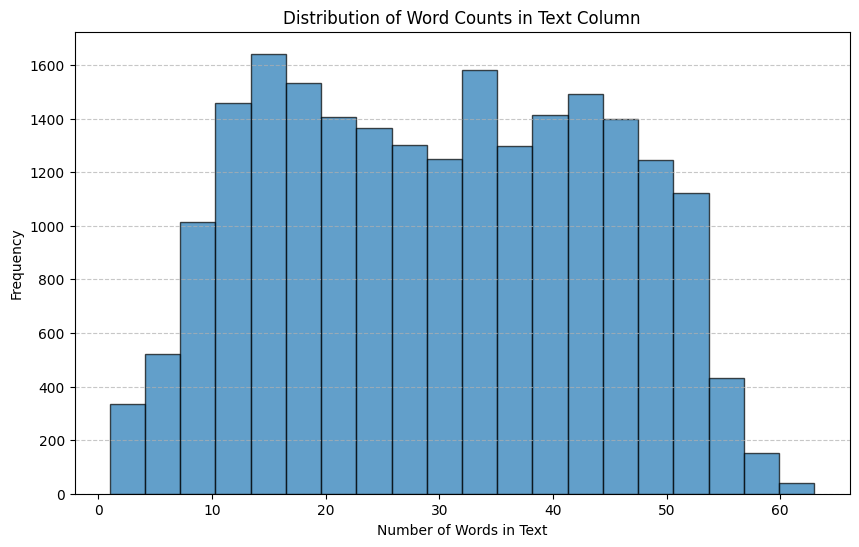

In [ ]:
import matplotlib.pyplot as plt

def plot_word_length(csv_file, text_column):
    # Load the CSV file
    df = pd.read_csv(csv_file)

    # Count the number of words in each row of the text column
    df['word_count'] = df[text_column].astype(str).apply(lambda x: len(x.split()))

    # Plot the word count distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['word_count'], bins=20, edgecolor='black', alpha=0.7)
    plt.xlabel('Number of Words in Text')
    plt.ylabel('Frequency')
    plt.title('Distribution of Word Counts in Text Column')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_word_length('bluesky.csv', 'Text')

In [ ]:
# File paths for the three CSV files
train_csv = "train.csv"
val_csv = "validate.csv"
test_csv = "test.csv"

# Hyperparameters
max_length = 64
batch_size = 16
learning_rate = 2e-5
epochs = 100
num_classes = 2
bert_model_name = "bert-base-uncased"

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

# Create datasets
train_dataset = CSVDataset(train_csv, tokenizer, max_length)
val_dataset = CSVDataset(val_csv, tokenizer, max_length)
test_dataset = CSVDataset(test_csv, tokenizer, max_length)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = BERTWithDenseLayers(bert_model_name=bert_model_name)
model.to(device)

# Set up optimizer and loss function (only train the classifier parameters)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

Using device: cuda


In [ ]:
# Train the model
train_model(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=epochs,
    save_path="/content/bert_classifier_best.pt"
)

# Optional: Evaluate on test set using the best saved model
print("\nEvaluating best model on test set...")

Starting training for 100 epochs

Epoch 1/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.37it/s, loss=12.6163, accuracy=0.7119]



Validating...

Epoch 1/100 Results:
  Time: 63.91s
  Train Loss: 31.2697
  Train Accuracy: 0.7119
  Val Loss: 31.6821
  Val Accuracy: 0.7264

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.7264

Epoch 2/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=10.2680, accuracy=0.7288]



Validating...

Epoch 2/100 Results:
  Time: 63.73s
  Train Loss: 31.1218
  Train Accuracy: 0.7288
  Val Loss: 31.5441
  Val Accuracy: 0.7421

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.7421

Epoch 3/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.45it/s, loss=16.6811, accuracy=0.7524]



Validating...

Epoch 3/100 Results:
  Time: 63.70s
  Train Loss: 31.0052
  Train Accuracy: 0.7524
  Val Loss: 31.4363
  Val Accuracy: 0.7756

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.7756

Epoch 4/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.36it/s, loss=9.6952, accuracy=0.7646]



Validating...

Epoch 4/100 Results:
  Time: 63.99s
  Train Loss: 30.9103
  Train Accuracy: 0.7646
  Val Loss: 31.3926
  Val Accuracy: 0.7363

  Current best accuracy: 0.7756 (no save)

Epoch 5/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.47it/s, loss=8.1475, accuracy=0.7554]



Validating...

Epoch 5/100 Results:
  Time: 63.71s
  Train Loss: 30.8479
  Train Accuracy: 0.7554
  Val Loss: 31.3630
  Val Accuracy: 0.7309

  Current best accuracy: 0.7756 (no save)

Epoch 6/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.47it/s, loss=14.3971, accuracy=0.7607]



Validating...

Epoch 6/100 Results:
  Time: 63.70s
  Train Loss: 30.8010
  Train Accuracy: 0.7607
  Val Loss: 31.2787
  Val Accuracy: 0.7519

  Current best accuracy: 0.7756 (no save)

Epoch 7/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.62it/s, loss=16.9648, accuracy=0.7641]



Validating...

Epoch 7/100 Results:
  Time: 63.19s
  Train Loss: 30.7679
  Train Accuracy: 0.7641
  Val Loss: 31.3504
  Val Accuracy: 0.7287

  Current best accuracy: 0.7756 (no save)

Epoch 8/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.59it/s, loss=10.5061, accuracy=0.7724]



Validating...

Epoch 8/100 Results:
  Time: 63.30s
  Train Loss: 30.7498
  Train Accuracy: 0.7724
  Val Loss: 31.2230
  Val Accuracy: 0.7774

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.7774

Epoch 9/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.59it/s, loss=12.1906, accuracy=0.7784]



Validating...

Epoch 9/100 Results:
  Time: 63.27s
  Train Loss: 30.7090
  Train Accuracy: 0.7784
  Val Loss: 31.2390
  Val Accuracy: 0.7591

  Current best accuracy: 0.7774 (no save)

Epoch 10/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.55it/s, loss=16.7185, accuracy=0.7785]



Validating...

Epoch 10/100 Results:
  Time: 63.31s
  Train Loss: 30.6913
  Train Accuracy: 0.7785
  Val Loss: 31.1978
  Val Accuracy: 0.7707

  Current best accuracy: 0.7774 (no save)

Epoch 11/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.53it/s, loss=11.5745, accuracy=0.7815]



Validating...

Epoch 11/100 Results:
  Time: 63.29s
  Train Loss: 30.6775
  Train Accuracy: 0.7815
  Val Loss: 31.1975
  Val Accuracy: 0.7684

  Current best accuracy: 0.7774 (no save)

Epoch 12/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.55it/s, loss=5.1386, accuracy=0.7856]



Validating...

Epoch 12/100 Results:
  Time: 63.32s
  Train Loss: 30.6749
  Train Accuracy: 0.7856
  Val Loss: 31.1955
  Val Accuracy: 0.7725

  Current best accuracy: 0.7774 (no save)

Epoch 13/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.59it/s, loss=9.9122, accuracy=0.7873]



Validating...

Epoch 13/100 Results:
  Time: 63.30s
  Train Loss: 30.6536
  Train Accuracy: 0.7873
  Val Loss: 31.1605
  Val Accuracy: 0.7863

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.7863

Epoch 14/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.58it/s, loss=9.5842, accuracy=0.7822]



Validating...

Epoch 14/100 Results:
  Time: 63.34s
  Train Loss: 30.6616
  Train Accuracy: 0.7822
  Val Loss: 31.1365
  Val Accuracy: 0.7993

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.7993

Epoch 15/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.54it/s, loss=14.7213, accuracy=0.7923]



Validating...

Epoch 15/100 Results:
  Time: 63.47s
  Train Loss: 30.6266
  Train Accuracy: 0.7923
  Val Loss: 31.1672
  Val Accuracy: 0.7792

  Current best accuracy: 0.7993 (no save)

Epoch 16/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.52it/s, loss=10.8227, accuracy=0.7909]



Validating...

Epoch 16/100 Results:
  Time: 63.51s
  Train Loss: 30.6505
  Train Accuracy: 0.7909
  Val Loss: 31.1405
  Val Accuracy: 0.8024

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.8024

Epoch 17/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.54it/s, loss=12.7453, accuracy=0.7832]



Validating...

Epoch 17/100 Results:
  Time: 63.47s
  Train Loss: 30.6632
  Train Accuracy: 0.7832
  Val Loss: 31.1469
  Val Accuracy: 0.7841

  Current best accuracy: 0.8024 (no save)

Epoch 18/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.52it/s, loss=14.3806, accuracy=0.7902]



Validating...

Epoch 18/100 Results:
  Time: 63.55s
  Train Loss: 30.5977
  Train Accuracy: 0.7902
  Val Loss: 31.1421
  Val Accuracy: 0.7819

  Current best accuracy: 0.8024 (no save)

Epoch 19/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.56it/s, loss=11.9450, accuracy=0.7918]



Validating...

Epoch 19/100 Results:
  Time: 63.28s
  Train Loss: 30.6059
  Train Accuracy: 0.7918
  Val Loss: 31.1201
  Val Accuracy: 0.7868

  Current best accuracy: 0.8024 (no save)

Epoch 20/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.47it/s, loss=7.7072, accuracy=0.7875]



Validating...

Epoch 20/100 Results:
  Time: 63.54s
  Train Loss: 30.6180
  Train Accuracy: 0.7875
  Val Loss: 31.1457
  Val Accuracy: 0.7877

  Current best accuracy: 0.8024 (no save)

Epoch 21/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.46it/s, loss=11.7791, accuracy=0.7926]



Validating...

Epoch 21/100 Results:
  Time: 63.61s
  Train Loss: 30.6114
  Train Accuracy: 0.7926
  Val Loss: 31.1048
  Val Accuracy: 0.7984

  Current best accuracy: 0.8024 (no save)

Epoch 22/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.54it/s, loss=14.1681, accuracy=0.7896]



Validating...

Epoch 22/100 Results:
  Time: 63.42s
  Train Loss: 30.5983
  Train Accuracy: 0.7896
  Val Loss: 31.1148
  Val Accuracy: 0.7926

  Current best accuracy: 0.8024 (no save)

Epoch 23/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.59it/s, loss=8.9505, accuracy=0.7874]



Validating...

Epoch 23/100 Results:
  Time: 63.28s
  Train Loss: 30.6250
  Train Accuracy: 0.7874
  Val Loss: 31.0909
  Val Accuracy: 0.8024

  Current best accuracy: 0.8024 (no save)

Epoch 24/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.59it/s, loss=11.4576, accuracy=0.7956]



Validating...

Epoch 24/100 Results:
  Time: 63.31s
  Train Loss: 30.5778
  Train Accuracy: 0.7956
  Val Loss: 31.1675
  Val Accuracy: 0.7810

  Current best accuracy: 0.8024 (no save)

Epoch 25/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.58it/s, loss=9.9470, accuracy=0.7897]



Validating...

Epoch 25/100 Results:
  Time: 63.34s
  Train Loss: 30.5982
  Train Accuracy: 0.7897
  Val Loss: 31.0833
  Val Accuracy: 0.8100

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.8100

Epoch 26/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.53it/s, loss=12.3679, accuracy=0.7954]



Validating...

Epoch 26/100 Results:
  Time: 63.49s
  Train Loss: 30.5901
  Train Accuracy: 0.7954
  Val Loss: 31.0796
  Val Accuracy: 0.8078

  Current best accuracy: 0.8100 (no save)

Epoch 27/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.52it/s, loss=11.4068, accuracy=0.7959]



Validating...

Epoch 27/100 Results:
  Time: 63.46s
  Train Loss: 30.5600
  Train Accuracy: 0.7959
  Val Loss: 31.1199
  Val Accuracy: 0.7926

  Current best accuracy: 0.8100 (no save)

Epoch 28/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.49it/s, loss=7.7345, accuracy=0.7915]



Validating...

Epoch 28/100 Results:
  Time: 63.46s
  Train Loss: 30.5855
  Train Accuracy: 0.7915
  Val Loss: 31.0801
  Val Accuracy: 0.7979

  Current best accuracy: 0.8100 (no save)

Epoch 29/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.29it/s, loss=11.7236, accuracy=0.7915]



Validating...

Epoch 29/100 Results:
  Time: 64.17s
  Train Loss: 30.5549
  Train Accuracy: 0.7915
  Val Loss: 31.0741
  Val Accuracy: 0.8024

  Current best accuracy: 0.8100 (no save)

Epoch 30/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.54it/s, loss=17.0694, accuracy=0.7934]



Validating...

Epoch 30/100 Results:
  Time: 63.34s
  Train Loss: 30.5791
  Train Accuracy: 0.7934
  Val Loss: 31.0997
  Val Accuracy: 0.7819

  Current best accuracy: 0.8100 (no save)

Epoch 31/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.58it/s, loss=12.4551, accuracy=0.7934]



Validating...

Epoch 31/100 Results:
  Time: 63.31s
  Train Loss: 30.5779
  Train Accuracy: 0.7934
  Val Loss: 31.0766
  Val Accuracy: 0.8038

  Current best accuracy: 0.8100 (no save)

Epoch 32/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.40it/s, loss=13.0450, accuracy=0.7940]



Validating...

Epoch 32/100 Results:
  Time: 63.97s
  Train Loss: 30.5509
  Train Accuracy: 0.7940
  Val Loss: 31.1637
  Val Accuracy: 0.7890

  Current best accuracy: 0.8100 (no save)

Epoch 33/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.53it/s, loss=14.1046, accuracy=0.7955]



Validating...

Epoch 33/100 Results:
  Time: 63.52s
  Train Loss: 30.5708
  Train Accuracy: 0.7955
  Val Loss: 31.2002
  Val Accuracy: 0.7783

  Current best accuracy: 0.8100 (no save)

Epoch 34/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.52it/s, loss=17.3632, accuracy=0.7927]



Validating...

Epoch 34/100 Results:
  Time: 63.59s
  Train Loss: 30.5705
  Train Accuracy: 0.7927
  Val Loss: 31.0724
  Val Accuracy: 0.8078

  Current best accuracy: 0.8100 (no save)

Epoch 35/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.45it/s, loss=11.4518, accuracy=0.7902]



Validating...

Epoch 35/100 Results:
  Time: 63.70s
  Train Loss: 30.5980
  Train Accuracy: 0.7902
  Val Loss: 31.2282
  Val Accuracy: 0.7792

  Current best accuracy: 0.8100 (no save)

Epoch 36/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.48it/s, loss=11.7071, accuracy=0.7913]



Validating...

Epoch 36/100 Results:
  Time: 63.49s
  Train Loss: 30.5630
  Train Accuracy: 0.7913
  Val Loss: 31.2258
  Val Accuracy: 0.7765

  Current best accuracy: 0.8100 (no save)

Epoch 37/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.39it/s, loss=9.3897, accuracy=0.7938]



Validating...

Epoch 37/100 Results:
  Time: 63.84s
  Train Loss: 30.5672
  Train Accuracy: 0.7938
  Val Loss: 31.0577
  Val Accuracy: 0.8020

  Current best accuracy: 0.8100 (no save)

Epoch 38/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=9.5614, accuracy=0.7969]



Validating...

Epoch 38/100 Results:
  Time: 63.84s
  Train Loss: 30.5484
  Train Accuracy: 0.7969
  Val Loss: 31.0727
  Val Accuracy: 0.8055

  Current best accuracy: 0.8100 (no save)

Epoch 39/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.36it/s, loss=11.9124, accuracy=0.7942]



Validating...

Epoch 39/100 Results:
  Time: 64.17s
  Train Loss: 30.5314
  Train Accuracy: 0.7942
  Val Loss: 31.1145
  Val Accuracy: 0.7921

  Current best accuracy: 0.8100 (no save)

Epoch 40/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.43it/s, loss=7.9496, accuracy=0.7928]



Validating...

Epoch 40/100 Results:
  Time: 63.91s
  Train Loss: 30.5709
  Train Accuracy: 0.7928
  Val Loss: 31.1514
  Val Accuracy: 0.7845

  Current best accuracy: 0.8100 (no save)

Epoch 41/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.39it/s, loss=11.8145, accuracy=0.7953]



Validating...

Epoch 41/100 Results:
  Time: 64.10s
  Train Loss: 30.5375
  Train Accuracy: 0.7953
  Val Loss: 31.0615
  Val Accuracy: 0.8042

  Current best accuracy: 0.8100 (no save)

Epoch 42/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=12.2112, accuracy=0.7919]



Validating...

Epoch 42/100 Results:
  Time: 63.91s
  Train Loss: 30.5572
  Train Accuracy: 0.7919
  Val Loss: 31.1886
  Val Accuracy: 0.7760

  Current best accuracy: 0.8100 (no save)

Epoch 43/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:56<00:00, 15.17it/s, loss=14.0000, accuracy=0.7967]



Validating...

Epoch 43/100 Results:
  Time: 64.82s
  Train Loss: 30.5208
  Train Accuracy: 0.7967
  Val Loss: 31.2070
  Val Accuracy: 0.7787

  Current best accuracy: 0.8100 (no save)

Epoch 44/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=12.1223, accuracy=0.7914]



Validating...

Epoch 44/100 Results:
  Time: 63.70s
  Train Loss: 30.5681
  Train Accuracy: 0.7914
  Val Loss: 31.1755
  Val Accuracy: 0.7805

  Current best accuracy: 0.8100 (no save)

Epoch 45/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=11.5790, accuracy=0.7955]



Validating...

Epoch 45/100 Results:
  Time: 63.68s
  Train Loss: 30.5592
  Train Accuracy: 0.7955
  Val Loss: 31.0911
  Val Accuracy: 0.7979

  Current best accuracy: 0.8100 (no save)

Epoch 46/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=5.2425, accuracy=0.7975]



Validating...

Epoch 46/100 Results:
  Time: 63.77s
  Train Loss: 30.5445
  Train Accuracy: 0.7975
  Val Loss: 31.0403
  Val Accuracy: 0.8082

  Current best accuracy: 0.8100 (no save)

Epoch 47/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.46it/s, loss=14.0766, accuracy=0.7975]



Validating...

Epoch 47/100 Results:
  Time: 63.79s
  Train Loss: 30.5172
  Train Accuracy: 0.7975
  Val Loss: 31.1117
  Val Accuracy: 0.7908

  Current best accuracy: 0.8100 (no save)

Epoch 48/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.47it/s, loss=14.5309, accuracy=0.7986]



Validating...

Epoch 48/100 Results:
  Time: 63.71s
  Train Loss: 30.5359
  Train Accuracy: 0.7986
  Val Loss: 31.0864
  Val Accuracy: 0.7939

  Current best accuracy: 0.8100 (no save)

Epoch 49/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.52it/s, loss=4.5885, accuracy=0.7957]



Validating...

Epoch 49/100 Results:
  Time: 63.53s
  Train Loss: 30.5410
  Train Accuracy: 0.7957
  Val Loss: 31.0579
  Val Accuracy: 0.7957

  Current best accuracy: 0.8100 (no save)

Epoch 50/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.51it/s, loss=17.1478, accuracy=0.7978]



Validating...

Epoch 50/100 Results:
  Time: 63.55s
  Train Loss: 30.5254
  Train Accuracy: 0.7978
  Val Loss: 31.0349
  Val Accuracy: 0.8118

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.8118

Epoch 51/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.50it/s, loss=12.1807, accuracy=0.7934]



Validating...

Epoch 51/100 Results:
  Time: 63.58s
  Train Loss: 30.5327
  Train Accuracy: 0.7934
  Val Loss: 31.1084
  Val Accuracy: 0.7908

  Current best accuracy: 0.8118 (no save)

Epoch 52/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.45it/s, loss=8.8426, accuracy=0.7980]



Validating...

Epoch 52/100 Results:
  Time: 63.72s
  Train Loss: 30.5194
  Train Accuracy: 0.7980
  Val Loss: 31.0387
  Val Accuracy: 0.8118

  Current best accuracy: 0.8118 (no save)

Epoch 53/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.46it/s, loss=11.4810, accuracy=0.7983]



Validating...

Epoch 53/100 Results:
  Time: 63.57s
  Train Loss: 30.5402
  Train Accuracy: 0.7983
  Val Loss: 31.1027
  Val Accuracy: 0.7930

  Current best accuracy: 0.8118 (no save)

Epoch 54/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.45it/s, loss=14.9886, accuracy=0.7953]



Validating...

Epoch 54/100 Results:
  Time: 63.61s
  Train Loss: 30.5153
  Train Accuracy: 0.7953
  Val Loss: 31.0580
  Val Accuracy: 0.7997

  Current best accuracy: 0.8118 (no save)

Epoch 55/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.41it/s, loss=11.8185, accuracy=0.7996]



Validating...

Epoch 55/100 Results:
  Time: 63.86s
  Train Loss: 30.5268
  Train Accuracy: 0.7996
  Val Loss: 31.1143
  Val Accuracy: 0.7863

  Current best accuracy: 0.8118 (no save)

Epoch 56/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.48it/s, loss=9.6461, accuracy=0.7915]



Validating...

Epoch 56/100 Results:
  Time: 63.70s
  Train Loss: 30.5747
  Train Accuracy: 0.7915
  Val Loss: 31.2330
  Val Accuracy: 0.7760

  Current best accuracy: 0.8118 (no save)

Epoch 57/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.47it/s, loss=11.9478, accuracy=0.7923]



Validating...

Epoch 57/100 Results:
  Time: 63.73s
  Train Loss: 30.5572
  Train Accuracy: 0.7923
  Val Loss: 31.0809
  Val Accuracy: 0.7975

  Current best accuracy: 0.8118 (no save)

Epoch 58/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.43it/s, loss=12.7191, accuracy=0.7970]



Validating...

Epoch 58/100 Results:
  Time: 63.88s
  Train Loss: 30.5309
  Train Accuracy: 0.7970
  Val Loss: 31.0370
  Val Accuracy: 0.8064

  Current best accuracy: 0.8118 (no save)

Epoch 59/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.46it/s, loss=12.0301, accuracy=0.7943]



Validating...

Epoch 59/100 Results:
  Time: 63.78s
  Train Loss: 30.5138
  Train Accuracy: 0.7943
  Val Loss: 31.0340
  Val Accuracy: 0.8006

  Current best accuracy: 0.8118 (no save)

Epoch 60/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.45it/s, loss=12.1791, accuracy=0.7964]



Validating...

Epoch 60/100 Results:
  Time: 63.67s
  Train Loss: 30.5469
  Train Accuracy: 0.7964
  Val Loss: 31.2657
  Val Accuracy: 0.7675

  Current best accuracy: 0.8118 (no save)

Epoch 61/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=12.3312, accuracy=0.7976]



Validating...

Epoch 61/100 Results:
  Time: 63.63s
  Train Loss: 30.5487
  Train Accuracy: 0.7976
  Val Loss: 31.0363
  Val Accuracy: 0.8078

  Current best accuracy: 0.8118 (no save)

Epoch 62/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=14.5933, accuracy=0.7984]



Validating...

Epoch 62/100 Results:
  Time: 63.66s
  Train Loss: 30.5139
  Train Accuracy: 0.7984
  Val Loss: 31.0717
  Val Accuracy: 0.7957

  Current best accuracy: 0.8118 (no save)

Epoch 63/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=10.2478, accuracy=0.7948]



Validating...

Epoch 63/100 Results:
  Time: 63.93s
  Train Loss: 30.5481
  Train Accuracy: 0.7948
  Val Loss: 31.0849
  Val Accuracy: 0.7903

  Current best accuracy: 0.8118 (no save)

Epoch 64/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.36it/s, loss=12.0799, accuracy=0.7982]



Validating...

Epoch 64/100 Results:
  Time: 64.09s
  Train Loss: 30.5304
  Train Accuracy: 0.7982
  Val Loss: 31.1184
  Val Accuracy: 0.7863

  Current best accuracy: 0.8118 (no save)

Epoch 65/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=12.9440, accuracy=0.7961]



Validating...

Epoch 65/100 Results:
  Time: 63.80s
  Train Loss: 30.5349
  Train Accuracy: 0.7961
  Val Loss: 31.0416
  Val Accuracy: 0.8127

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.8127

Epoch 66/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.43it/s, loss=8.2029, accuracy=0.7970]



Validating...

Epoch 66/100 Results:
  Time: 63.90s
  Train Loss: 30.5230
  Train Accuracy: 0.7970
  Val Loss: 31.0353
  Val Accuracy: 0.8091

  Current best accuracy: 0.8127 (no save)

Epoch 67/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.32it/s, loss=11.9171, accuracy=0.8000]



Validating...

Epoch 67/100 Results:
  Time: 64.25s
  Train Loss: 30.5225
  Train Accuracy: 0.8000
  Val Loss: 31.0220
  Val Accuracy: 0.8064

  Current best accuracy: 0.8127 (no save)

Epoch 68/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.40it/s, loss=11.7284, accuracy=0.8000]



Validating...

Epoch 68/100 Results:
  Time: 63.97s
  Train Loss: 30.5212
  Train Accuracy: 0.8000
  Val Loss: 31.1096
  Val Accuracy: 0.7899

  Current best accuracy: 0.8127 (no save)

Epoch 69/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.46it/s, loss=12.8146, accuracy=0.7999]



Validating...

Epoch 69/100 Results:
  Time: 63.68s
  Train Loss: 30.5050
  Train Accuracy: 0.7999
  Val Loss: 31.0256
  Val Accuracy: 0.8091

  Current best accuracy: 0.8127 (no save)

Epoch 70/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=14.5122, accuracy=0.7981]



Validating...

Epoch 70/100 Results:
  Time: 63.63s
  Train Loss: 30.5291
  Train Accuracy: 0.7981
  Val Loss: 31.0607
  Val Accuracy: 0.7988

  Current best accuracy: 0.8127 (no save)

Epoch 71/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=7.1091, accuracy=0.7953]



Validating...

Epoch 71/100 Results:
  Time: 63.74s
  Train Loss: 30.5377
  Train Accuracy: 0.7953
  Val Loss: 31.0872
  Val Accuracy: 0.7921

  Current best accuracy: 0.8127 (no save)

Epoch 72/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.37it/s, loss=14.6415, accuracy=0.7992]



Validating...

Epoch 72/100 Results:
  Time: 64.07s
  Train Loss: 30.5286
  Train Accuracy: 0.7992
  Val Loss: 31.0890
  Val Accuracy: 0.7957

  Current best accuracy: 0.8127 (no save)

Epoch 73/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.33it/s, loss=11.4692, accuracy=0.7988]



Validating...

Epoch 73/100 Results:
  Time: 64.21s
  Train Loss: 30.5071
  Train Accuracy: 0.7988
  Val Loss: 31.0736
  Val Accuracy: 0.7979

  Current best accuracy: 0.8127 (no save)

Epoch 74/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=7.2793, accuracy=0.7964]



Validating...

Epoch 74/100 Results:
  Time: 63.92s
  Train Loss: 30.5245
  Train Accuracy: 0.7964
  Val Loss: 31.0253
  Val Accuracy: 0.8029

  Current best accuracy: 0.8127 (no save)

Epoch 75/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=7.2431, accuracy=0.7978]



Validating...

Epoch 75/100 Results:
  Time: 63.91s
  Train Loss: 30.5116
  Train Accuracy: 0.7978
  Val Loss: 31.0089
  Val Accuracy: 0.8154

  ✓ SAVING NEW BEST MODEL with validation accuracy: 0.8154

Epoch 76/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=9.6526, accuracy=0.7992]



Validating...

Epoch 76/100 Results:
  Time: 63.83s
  Train Loss: 30.4878
  Train Accuracy: 0.7992
  Val Loss: 31.0345
  Val Accuracy: 0.8015

  Current best accuracy: 0.8154 (no save)

Epoch 77/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.41it/s, loss=1.2247, accuracy=0.7977]



Validating...

Epoch 77/100 Results:
  Time: 63.94s
  Train Loss: 30.5132
  Train Accuracy: 0.7977
  Val Loss: 31.0417
  Val Accuracy: 0.8011

  Current best accuracy: 0.8154 (no save)

Epoch 78/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.43it/s, loss=10.2311, accuracy=0.7985]



Validating...

Epoch 78/100 Results:
  Time: 63.79s
  Train Loss: 30.5213
  Train Accuracy: 0.7985
  Val Loss: 31.0651
  Val Accuracy: 0.7988

  Current best accuracy: 0.8154 (no save)

Epoch 79/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.40it/s, loss=11.3425, accuracy=0.7960]



Validating...

Epoch 79/100 Results:
  Time: 63.75s
  Train Loss: 30.5086
  Train Accuracy: 0.7960
  Val Loss: 31.1542
  Val Accuracy: 0.7796

  Current best accuracy: 0.8154 (no save)

Epoch 80/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.38it/s, loss=4.6268, accuracy=0.8006]



Validating...

Epoch 80/100 Results:
  Time: 63.86s
  Train Loss: 30.4980
  Train Accuracy: 0.8006
  Val Loss: 31.0068
  Val Accuracy: 0.8149

  Current best accuracy: 0.8154 (no save)

Epoch 81/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.35it/s, loss=12.7029, accuracy=0.7975]



Validating...

Epoch 81/100 Results:
  Time: 64.07s
  Train Loss: 30.4864
  Train Accuracy: 0.7975
  Val Loss: 31.0440
  Val Accuracy: 0.7975

  Current best accuracy: 0.8154 (no save)

Epoch 82/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.43it/s, loss=9.1113, accuracy=0.8017]



Validating...

Epoch 82/100 Results:
  Time: 63.86s
  Train Loss: 30.5074
  Train Accuracy: 0.8017
  Val Loss: 31.0472
  Val Accuracy: 0.7993

  Current best accuracy: 0.8154 (no save)

Epoch 83/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=9.7517, accuracy=0.7982]



Validating...

Epoch 83/100 Results:
  Time: 63.81s
  Train Loss: 30.5191
  Train Accuracy: 0.7982
  Val Loss: 31.0965
  Val Accuracy: 0.7944

  Current best accuracy: 0.8154 (no save)

Epoch 84/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.43it/s, loss=12.8531, accuracy=0.7997]



Validating...

Epoch 84/100 Results:
  Time: 63.86s
  Train Loss: 30.5063
  Train Accuracy: 0.7997
  Val Loss: 31.0435
  Val Accuracy: 0.8002

  Current best accuracy: 0.8154 (no save)

Epoch 85/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=11.9993, accuracy=0.8001]



Validating...

Epoch 85/100 Results:
  Time: 63.88s
  Train Loss: 30.5151
  Train Accuracy: 0.8001
  Val Loss: 31.1498
  Val Accuracy: 0.7801

  Current best accuracy: 0.8154 (no save)

Epoch 86/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:54<00:00, 15.48it/s, loss=17.1336, accuracy=0.7986]



Validating...

Epoch 86/100 Results:
  Time: 63.62s
  Train Loss: 30.5059
  Train Accuracy: 0.7986
  Val Loss: 31.0436
  Val Accuracy: 0.7979

  Current best accuracy: 0.8154 (no save)

Epoch 87/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.44it/s, loss=16.6683, accuracy=0.8000]



Validating...

Epoch 87/100 Results:
  Time: 63.64s
  Train Loss: 30.5115
  Train Accuracy: 0.8000
  Val Loss: 31.0176
  Val Accuracy: 0.8105

  Current best accuracy: 0.8154 (no save)

Epoch 88/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.39it/s, loss=9.1576, accuracy=0.7997]



Validating...

Epoch 88/100 Results:
  Time: 63.80s
  Train Loss: 30.4917
  Train Accuracy: 0.7997
  Val Loss: 31.0912
  Val Accuracy: 0.7939

  Current best accuracy: 0.8154 (no save)

Epoch 89/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.41it/s, loss=14.9572, accuracy=0.8009]



Validating...

Epoch 89/100 Results:
  Time: 63.81s
  Train Loss: 30.4811
  Train Accuracy: 0.8009
  Val Loss: 31.0473
  Val Accuracy: 0.7975

  Current best accuracy: 0.8154 (no save)

Epoch 90/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=11.8645, accuracy=0.7975]



Validating...

Epoch 90/100 Results:
  Time: 63.89s
  Train Loss: 30.5162
  Train Accuracy: 0.7975
  Val Loss: 31.0065
  Val Accuracy: 0.8127

  Current best accuracy: 0.8154 (no save)

Epoch 91/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=11.5359, accuracy=0.8000]



Validating...

Epoch 91/100 Results:
  Time: 63.88s
  Train Loss: 30.4986
  Train Accuracy: 0.8000
  Val Loss: 31.0590
  Val Accuracy: 0.8024

  Current best accuracy: 0.8154 (no save)

Epoch 92/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.42it/s, loss=8.9393, accuracy=0.8026]



Validating...

Epoch 92/100 Results:
  Time: 63.89s
  Train Loss: 30.4773
  Train Accuracy: 0.8026
  Val Loss: 31.0399
  Val Accuracy: 0.8006

  Current best accuracy: 0.8154 (no save)

Epoch 93/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.45it/s, loss=12.2271, accuracy=0.7973]



Validating...

Epoch 93/100 Results:
  Time: 63.80s
  Train Loss: 30.5220
  Train Accuracy: 0.7973
  Val Loss: 31.0561
  Val Accuracy: 0.7970

  Current best accuracy: 0.8154 (no save)

Epoch 94/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.31it/s, loss=9.7286, accuracy=0.8002]



Validating...

Epoch 94/100 Results:
  Time: 64.40s
  Train Loss: 30.5044
  Train Accuracy: 0.8002
  Val Loss: 31.0101
  Val Accuracy: 0.8105

  Current best accuracy: 0.8154 (no save)

Epoch 95/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.28it/s, loss=11.9536, accuracy=0.8012]



Validating...

Epoch 95/100 Results:
  Time: 64.28s
  Train Loss: 30.4875
  Train Accuracy: 0.8012
  Val Loss: 31.1172
  Val Accuracy: 0.7890

  Current best accuracy: 0.8154 (no save)

Epoch 96/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.25it/s, loss=14.7575, accuracy=0.8029]



Validating...

Epoch 96/100 Results:
  Time: 64.32s
  Train Loss: 30.5028
  Train Accuracy: 0.8029
  Val Loss: 31.1638
  Val Accuracy: 0.7819

  Current best accuracy: 0.8154 (no save)

Epoch 97/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.24it/s, loss=11.3947, accuracy=0.8016]



Validating...

Epoch 97/100 Results:
  Time: 64.34s
  Train Loss: 30.4836
  Train Accuracy: 0.8016
  Val Loss: 31.0133
  Val Accuracy: 0.8051

  Current best accuracy: 0.8154 (no save)

Epoch 98/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [01:01<00:00, 13.81it/s, loss=17.0081, accuracy=0.8020]



Validating...

Epoch 98/100 Results:
  Time: 71.02s
  Train Loss: 30.4772
  Train Accuracy: 0.8020
  Val Loss: 31.0350
  Val Accuracy: 0.7984

  Current best accuracy: 0.8154 (no save)

Epoch 99/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:58<00:00, 14.67it/s, loss=11.5928, accuracy=0.7961]



Validating...

Epoch 99/100 Results:
  Time: 66.74s
  Train Loss: 30.4970
  Train Accuracy: 0.7961
  Val Loss: 31.1078
  Val Accuracy: 0.7854

  Current best accuracy: 0.8154 (no save)

Epoch 100/100
------------------------------------------------------------


Training: 100%|██████████| 851/851 [00:55<00:00, 15.41it/s, loss=7.0011, accuracy=0.8017]



Validating...

Epoch 100/100 Results:
  Time: 63.84s
  Train Loss: 30.4888
  Train Accuracy: 0.8017
  Val Loss: 31.0450
  Val Accuracy: 0.7993

  Current best accuracy: 0.8154 (no save)

Training completed in 6397.40s
Best validation accuracy: 0.8154

Evaluating best model on test set...


In [ ]:
# Load the best model
checkpoint = torch.load("/content/bert_classifier_best.pt")
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate on test set
test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

<ipython-input-12-46843de1dab1>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/bert_classifier_best.pt")


Test Loss: 30.9605, Test Accuracy: 0.8176


In [ ]:
source_file = '/content/bert_classifier_best.pt'
destination_path = '/content/drive/MyDrive/BXT/bert_classifier_best.pt'

!cp "{source_file}" "{destination_path}"
print(f"File '{source_file}' copied to '{destination_path}'")

File '/content/bert_classifier_best.pt' copied to '/content/drive/MyDrive/BXT/bert_classifier_best.pt'


In [ ]:
# Prediction Dataset class (doesn't require labels)
class PredictionDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=64):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Convert to string to handle non-string inputs

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
        }

# Function to make predictions on a CSV file and save results
def predict_on_csv(model, tokenizer, csv_file_path, batch_size=32, output_csv_path=None, device=None):
    """
    Make predictions on a CSV file's 'text' column and save results.

    Args:
        model: The trained BERTWithDenseLayers model
        tokenizer: The BERT tokenizer
        csv_file_path: Path to the CSV file containing 'text' column
        batch_size: Batch size for processing
        output_csv_path: Path to save results (if None, modifies original file)
        device: Device to run inference on (if None, will detect)

    Returns:
        DataFrame with predictions added
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if output_csv_path is None:
        output_csv_path = csv_file_path

    # Read the CSV file
    print(f"Reading CSV file: {csv_file_path}")
    df = pd.read_csv(csv_file_path)

    # Check if 'text' column exists
    if 'Text' not in df.columns:
        raise ValueError("CSV file must contain a 'text' column")

    # Convert 'text' column to string type
    df['Text'] = df['Text'].astype(str)

    # Create dataset and dataloader
    prediction_dataset = PredictionDataset(df['Text'].values, tokenizer)
    prediction_dataloader = DataLoader(prediction_dataset, batch_size=batch_size)

    # Set model to evaluation mode
    model.eval()

    # Make predictions
    print("Making predictions...")
    predictions = []
    prediction_probs = []

    with torch.no_grad():
        for batch in tqdm(prediction_dataloader, desc="Predicting"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            outputs = outputs.squeeze(-1)

            # Get probabilities and predictions
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)

            prediction_probs.extend(probs)
            predictions.extend(preds)

    # Add predictions to the dataframe
    df['prediction'] = predictions
    df['prediction_probability'] = prediction_probs

    # Save results
    print(f"Saving predictions to: {output_csv_path}")
    df.to_csv(output_csv_path, index=False)

    print(f"Predictions complete. Found {sum(predictions)} positive and {len(predictions) - sum(predictions)} negative samples.")

    return df

def predict_csv_example():
    # Path to your prediction CSV file
    prediction_csv = "bluesky.csv"

    # Path to your saved model
    model_path = "/content/bert_classifier_best.pt"

    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

    # Initialize the model
    model = BERTWithDenseLayers(bert_model_name="bert-base-uncased")

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Load the saved model weights
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    # Make predictions and save results
    # This will add 'prediction' and 'prediction_probability' columns to the CSV
    results_df = predict_on_csv(
        model=model,
        tokenizer=tokenizer,
        csv_file_path=prediction_csv,
        batch_size=1,
        output_csv_path="predict_bert.csv",  # Set to None to overwrite original file
        device=device
    )

    print("Prediction process complete!")

In [ ]:
predict_csv_example()

Using device: cuda


<ipython-input-26-237915f19a98>:117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


Reading CSV file: bluesky.csv
Making predictions...


Predicting: 100%|██████████| 22002/22002 [03:44<00:00, 98.22it/s] 


Saving predictions to: predict_bert.csv
Predictions complete. Found 17044 positive and 4958 negative samples.
Prediction process complete!


In [ ]:
df = pd.read_csv('predict_bert.csv')
count1 = (df['prediction'] == 0).sum()
count0 = (df['prediction'] == 1).sum()
print(count1, count0)

4958 17044
